# Candle Dataset Cleaning

After running the first training job on the full dataset, we can see that despite the training loss decreasing, the validation loss is remaining fairly constant. As a potential remedy, we are going to try removing all of the rows from a closed market from the dataset. This will have a few advantages:
1. It will drasitcally reduce the size of the data by approximately 55 - 60%, by keeping only the examples that are relevant to the task we need to perform. 
2. It will ensure that the loss metrics are mearusing the models performnace on market data where trading is occuring. Currently, the loss function is likely dilluted, as so much of the data is just a flat time-series, that the model is likely performing perfectly on these examples, causing the loss metric to be diluted, and likely not allowing a high enough gradient to be built up for the backward pass.

## Plan for Cleaning Data 

1. Remove any rows where the market is closed. We will never be using this in the actual model.
2. This should give us a a couple hundred time-series per ticker. We want to create a time-series ID for each continuous time series in the dataset. This will be used as a column ID.
3. Then iterate over each ticker. For each ticker:
 - Use our date indicices, to create a train, validation, and test set for that ticker. Be sure that the date the sets do not slice any time-series (e.g. each of the 3 sets should have a unique set of time-series IDs)
 - Append eacah of the three sets to a master train, validation, and test set respectively. 
 - These steps will replace the current `select_by_index` usage
4. Train the `TimeSeriesPreprocessor` on the train set
5. Create the train, validation, and test datasets, using the trained preprocessor



In [14]:
# Standard
import os
import random

# Third Party
from transformers import (
    EarlyStoppingCallback,
    PatchTSMixerConfig,
    PatchTSMixerForPrediction,
    Trainer,
    TrainingArguments,
)
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split

# First Party
from tsfm_public.toolkit.dataset import ForecastDFDataset
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor


In [15]:
# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

## Dataset Preprocessing

We want to meticulously craft our examples for each trading day. Our primary focus here is to ensure that the model only is ever asked to forecast into live market data. We need it to understand this type of forecasting, and not be thrown off at all by examples from extended hours trading.

There are a few general steps we must take:
1. Ensure that all the data from the closed market is removed from the dataset, as this data will never be used in context or in forecasting.
2. Ensure that the timestamps are localized to America/New_York, so that we can get accurate date_strings to use for identifying each trading day.

In [16]:
# Load the Dataset from the CSV file
DATA_DIR = "/home/ubuntu/verb-workspace/data" # set this accordingly to the location of the data

TRAIN_DATASET = f"{DATA_DIR}/1min-candles-train.csv"
VALID_DATASET = f"{DATA_DIR}/1min-candles-valid.csv"
TEST_DATASET = f"{DATA_DIR}/1min-candles-test.csv"

timestamp_col = 't'

train_data = pd.read_csv(
    TRAIN_DATASET,
    parse_dates=[timestamp_col]
)

valid_data = pd.read_csv(
    VALID_DATASET,
    parse_dates=[timestamp_col]
)

test_data = pd.read_csv(
    TEST_DATASET,
    parse_dates=[timestamp_col]
)

In [17]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 937440 entries, 0 to 937439
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   t                937440 non-null  object 
 1   targ_o           937440 non-null  float64
 2   targ_h           937440 non-null  float64
 3   targ_l           937440 non-null  float64
 4   targ_c           937440 non-null  float64
 5   targ_v           937440 non-null  float64
 6   market_extended  937440 non-null  int64  
 7   market_open      937440 non-null  int64  
 8   ticker           937440 non-null  object 
 9   date_string      937440 non-null  object 
dtypes: float64(5), int64(2), object(3)
memory usage: 71.5+ MB


In [18]:
from polygon import RESTClient

POLYGON_API_KEY = "XRcvi1wdOpza2JAdKVigSjL5fzXtwhEG"
polygon = RESTClient(api_key=POLYGON_API_KEY)

def fetch_vwap(ticker: str, start: pd.Timestamp, end: pd.Timestamp):
    start_ms = int(start.timestamp() * 1000)
    end_ms = int(end.timestamp() * 1000)
    aggs = polygon.get_aggs(ticker=ticker, multiplier=1, timespan='minute', from_=start_ms, to=end_ms, limit=50000)

    series = [{'t': agg.timestamp, 'vwap': agg.vwap} for agg in aggs]
    df = pd.DataFrame(series)
    return df

In [19]:
# We need to fetch the VWAP for each row in the dataset
from tqdm import tqdm

df = pd.concat([train_data, valid_data, test_data])

# Iterate over the lists of groups
groups = df.groupby(["ticker", "date_string"])
vwap_dfs = []
for (ticker, date_string), group in tqdm(groups, total=len(groups)):
    start_ts = group['t'].iloc[0]
    end_ts = group['t'].iloc[-1] + pd.Timedelta(minutes=1)

    _df = fetch_vwap(ticker, start_ts, end_ts)
    _df['ticker'] = ticker
    _df['date_string'] = date_string
    vwap_dfs.append(_df)



100%|██████████| 1861/1861 [02:21<00:00, 13.16it/s]


In [20]:
vwap_df = pd.concat(vwap_dfs)

vwap_df['t'] = pd.to_datetime(vwap_df['t'], unit='ms', utc=True).dt.tz_convert('America/New_York')
vwap_df

,t,vwap,ticker,date_string
0,2023-01-03 05:33:00-05:00,130.8009,AAPL,2023-01-03
1,2023-01-03 05:42:00-05:00,130.8882,AAPL,2023-01-03
2,2023-01-03 05:43:00-05:00,130.9754,AAPL,2023-01-03
3,2023-01-03 05:44:00-05:00,130.9906,AAPL,2023-01-03
4,2023-01-03 05:46:00-05:00,131.0463,AAPL,2023-01-03
...,...,...,...,...
392,2023-11-17 15:56:00-05:00,249.7157,V,2023-11-17
393,2023-11-17 15:57:00-05:00,249.7169,V,2023-11-17
394,2023-11-17 15:58:00-05:00,249.7011,V,2023-11-17
395,2023-11-17 15:59:00-05:00,249.5993,V,2023-11-17


In [21]:
df['t'] = pd.to_datetime(df['t'], utc=True).dt.tz_convert('America/New_York')

merged_df = pd.merge(df, vwap_df, on=['t', 'ticker', 'date_string'], how='left')

# Rename columns
merged_df = merged_df.rename(columns={
    'market_open': 'cont_market_open',
    'market_extended': 'cont_market_extended',
    'vwap': 'obs_vwap'
})

desired_order = ['ticker', 'date_string', 't', 'targ_o', 'targ_h', 'targ_l', 'targ_c', 'targ_v', 'obs_vwap', 'cont_market_open', 'cont_market_extended']
merged_df = merged_df.reindex(columns=desired_order)

assert len(merged_df) == len(df)

merged_df

,ticker,date_string,t,targ_o,targ_h,targ_l,targ_c,targ_v,obs_vwap,cont_market_open,cont_market_extended
0,AAPL,2023-01-03,2023-01-03 05:30:00-05:00,130.80,130.80,130.80,130.80,0.0,NaN,0,1
1,AAPL,2023-01-03,2023-01-03 05:31:00-05:00,130.80,130.80,130.80,130.80,0.0,NaN,0,1
2,AAPL,2023-01-03,2023-01-03 05:32:00-05:00,130.80,130.80,130.80,130.80,0.0,NaN,0,1
3,AAPL,2023-01-03,2023-01-03 05:33:00-05:00,130.80,130.80,130.80,130.80,235.0,130.8009,0,1
4,AAPL,2023-01-03,2023-01-03 05:34:00-05:00,130.80,130.80,130.80,130.80,0.0,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1172425,V,2023-03-13,2023-03-13 15:55:00-04:00,214.78,214.85,214.34,214.34,46940.0,214.6342,1,0
1172426,V,2023-03-13,2023-03-13 15:56:00-04:00,214.34,214.62,214.31,214.36,73722.0,214.4226,1,0
1172427,V,2023-03-13,2023-03-13 15:57:00-04:00,214.37,214.52,214.32,214.49,63882.0,214.3948,1,0
1172428,V,2023-03-13,2023-03-13 15:58:00-04:00,214.51,214.52,214.28,214.28,56272.0,214.4258,1,0


In [26]:
# Fill NaN values with 0 in extended hours sections where calc_vwap is NaN
merged_df.loc[(merged_df['cont_market_extended'] == 1) & (merged_df['obs_vwap'].isna()), 'obs_vwap'] = 0

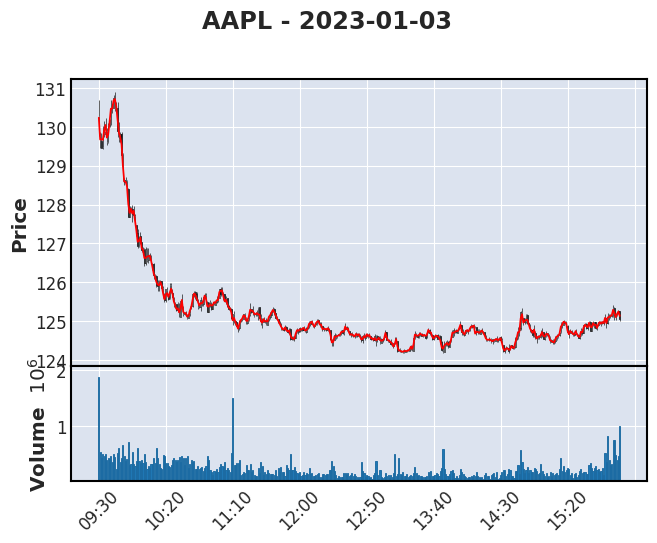

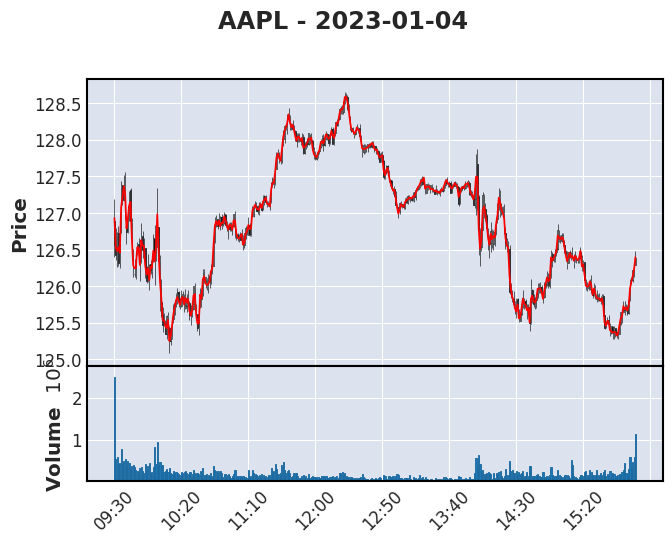

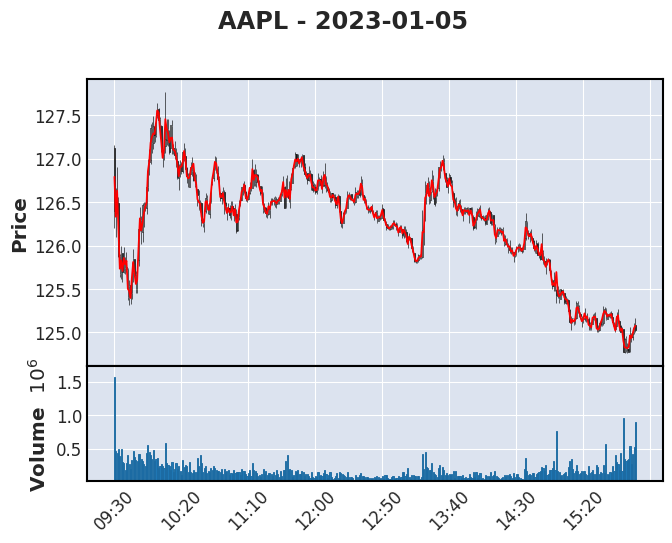

In [27]:
import mplfinance as mpf

groups = merged_df.groupby(['ticker', 'date_string'])

# Iterate over the first 3 groups
for (ticker, date_string), group_df in list(groups)[:3]:
    # Set the 't' column as the index
    group_df.set_index('t', inplace=True)

    # Trim the data to start at 9:30 AM
    group_df = group_df.loc[group_df.index >= group_df.index.normalize() + pd.Timedelta('9 hours 30 minutes')]
    
    # Rename columns to match mplfinance requirements
    group_df = group_df.rename(columns={
        'targ_o': 'Open',
        'targ_h': 'High',
        'targ_l': 'Low',
        'targ_c': 'Close',
        'targ_v': 'Volume'
    })
    
    # Create additional plot for VWAP on the main axes
    ap = [mpf.make_addplot(group_df['obs_vwap'], color='red', ylabel='VWAP')]
    
    # Create the candlestick chart with VWAP on the main axes
    mpf.plot(group_df, type='candle', addplot=ap, volume=True, title=f"{ticker} - {date_string}")

In [28]:
assert merged_df.isna().sum().sum() == 0

In [32]:
# Now, we want to annotate another pair of observed columns, which denotes weather or not the candle was a red or green candle

# Create a dummy column for green candles
merged_df['targ_green'] = ((merged_df['targ_c'] > merged_df['targ_o']).astype(int)
                             .mask(merged_df['targ_c'] == merged_df['targ_o'], 0))

# Create a dummy column for red candles
merged_df['targ_red'] = ((merged_df['targ_c'] < merged_df['targ_o']).astype(int)
                           .mask(merged_df['targ_c'] == merged_df['targ_o'], 0))

merged_df

,ticker,date_string,t,targ_o,targ_h,targ_l,targ_c,targ_v,obs_vwap,cont_market_open,cont_market_extended,targ_green,targ_reg,targ_red
0,AAPL,2023-01-03,2023-01-03 05:30:00-05:00,130.80,130.80,130.80,130.80,0.0,0.0000,0,1,0,0,0
1,AAPL,2023-01-03,2023-01-03 05:31:00-05:00,130.80,130.80,130.80,130.80,0.0,0.0000,0,1,0,0,0
2,AAPL,2023-01-03,2023-01-03 05:32:00-05:00,130.80,130.80,130.80,130.80,0.0,0.0000,0,1,0,0,0
3,AAPL,2023-01-03,2023-01-03 05:33:00-05:00,130.80,130.80,130.80,130.80,235.0,130.8009,0,1,0,0,0
4,AAPL,2023-01-03,2023-01-03 05:34:00-05:00,130.80,130.80,130.80,130.80,0.0,0.0000,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1172425,V,2023-03-13,2023-03-13 15:55:00-04:00,214.78,214.85,214.34,214.34,46940.0,214.6342,1,0,0,1,1
1172426,V,2023-03-13,2023-03-13 15:56:00-04:00,214.34,214.62,214.31,214.36,73722.0,214.4226,1,0,1,0,0
1172427,V,2023-03-13,2023-03-13 15:57:00-04:00,214.37,214.52,214.32,214.49,63882.0,214.3948,1,0,1,0,0
1172428,V,2023-03-13,2023-03-13 15:58:00-04:00,214.51,214.52,214.28,214.28,56272.0,214.4258,1,0,0,1,1


In [33]:
# Great, now that we have the VWAP, its time to reconstruct our train, valid, and test sets, and then save the data to the disk
desired_order = ['ticker', 'date_string', 't', 'targ_o', 'targ_h', 'targ_l', 'targ_c', 'targ_v', 'targ_red', 'targ_green', 'obs_vwap', 'cont_market_open', 'cont_market_extended']

train_data['t'] = pd.to_datetime(train_data['t'], utc=True).dt.tz_convert('America/New_York')
valid_data['t'] = pd.to_datetime(valid_data['t'], utc=True).dt.tz_convert('America/New_York')
test_data['t'] = pd.to_datetime(test_data['t'], utc=True).dt.tz_convert('America/New_York')

merged_train = pd.merge(train_data, merged_df[['t', 'ticker', 'date_string', 'obs_vwap', 'targ_red', 'targ_green']],
                        on=['t', 'ticker', 'date_string'], how='left')

merged_valid = pd.merge(valid_data, merged_df[['t', 'ticker', 'date_string', 'obs_vwap', 'targ_red', 'targ_green']],
                        on=['t', 'ticker', 'date_string'], how='left')

merged_test = pd.merge(test_data, merged_df[['t', 'ticker', 'date_string', 'obs_vwap', 'targ_red', 'targ_green']],
                       on=['t', 'ticker', 'date_string'], how='left')


merged_train = merged_train.rename(columns={
    'market_open': 'cont_market_open',
    'market_extended': 'cont_market_extended',
})
merged_valid = merged_valid.rename(columns={
    'market_open': 'cont_market_open',
    'market_extended': 'cont_market_extended',
})
merged_test = merged_test.rename(columns={
    'market_open': 'cont_market_open',
    'market_extended': 'cont_market_extended',
})


merged_train = merged_train.reindex(columns=desired_order)
merged_valid = merged_valid.reindex(columns=desired_order)
merged_test = merged_test.reindex(columns=desired_order)

assert len(merged_train) == len(train_data)
assert len(merged_valid) == len(valid_data)
assert len(merged_test) == len(test_data)

assert merged_train.isna().sum().sum() == 0
assert merged_valid.isna().sum().sum() == 0
assert merged_test.isna().sum().sum() == 0

In [34]:
merged_train

,ticker,date_string,t,targ_o,targ_h,targ_l,targ_c,targ_v,targ_red,targ_green,obs_vwap,cont_market_open,cont_market_extended
0,AAPL,2023-01-03,2023-01-03 05:30:00-05:00,130.80,130.8000,130.800,130.800,0.0,0,0,0.0000,0,1
1,AAPL,2023-01-03,2023-01-03 05:31:00-05:00,130.80,130.8000,130.800,130.800,0.0,0,0,0.0000,0,1
2,AAPL,2023-01-03,2023-01-03 05:32:00-05:00,130.80,130.8000,130.800,130.800,0.0,0,0,0.0000,0,1
3,AAPL,2023-01-03,2023-01-03 05:33:00-05:00,130.80,130.8000,130.800,130.800,235.0,0,0,130.8009,0,1
4,AAPL,2023-01-03,2023-01-03 05:34:00-05:00,130.80,130.8000,130.800,130.800,0.0,0,0,0.0000,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
937435,V,2023-11-17,2023-11-17 15:55:00-05:00,249.65,249.7277,249.620,249.680,20222.0,0,1,249.6721,1,0
937436,V,2023-11-17,2023-11-17 15:56:00-05:00,249.67,249.7700,249.670,249.705,24402.0,0,1,249.7157,1,0
937437,V,2023-11-17,2023-11-17 15:57:00-05:00,249.71,249.7600,249.670,249.725,29366.0,0,1,249.7169,1,0
937438,V,2023-11-17,2023-11-17 15:58:00-05:00,249.73,249.7300,249.655,249.660,29316.0,1,0,249.7011,1,0


In [35]:
TRAIN_DATASET_1_MIN = f"{DATA_DIR}/1min-candles-train-w-CANDLES.csv"
VALID_DATASET_1_MIN = f"{DATA_DIR}/1min-candles-valid-w-CANDLES.csv"
TEST_DATASET_1_MIN = f"{DATA_DIR}/1min-candles-test-w-CANDLES.csv"

merged_train.to_csv(TRAIN_DATASET_1_MIN, index=False)
merged_valid.to_csv(VALID_DATASET_1_MIN, index=False)
merged_test.to_csv(TEST_DATASET_1_MIN, index=False)